In [9]:
import matplotlib.pyplot as plt
from cmath import sqrt, cos, sin, asin, pi
import numpy as np
from mpmath import mp


def sign(n): return 1 if n >= 0 else -1

#-----------------------#
#   Physical Constants  #
#-----------------------#
e_charge = 1.602e-19
c_light = 2.99792458e8
hbar = 1.0545887e-34
keV = e_charge*1000.


#--------------------------#
#   User Input Variables   #
#--------------------------#
E = 4.0*keV
phi_a = 0.0
d_h = 3.1355e-10
pol = 's'

chi_r0 =-1.0843e-4
chi_i0 = 1.5225e-5

abs_chi_rh = 5.7236e-05
abs_chi_ih = 1.0601e-05  
arg_crh_over_cih = -pi
b = 0.017640/2*100 #Strain from COMSOL, so far works only scaled by 100 :( <-sad face




The amplitude ratio of reflected and refracted waves in a perfect crystal is given by 

$$\xi_j=\frac{D_{hj}}{D_{0j}}=\frac{S(C)S(\gamma_h)}{\sqrt{|\gamma|}}\frac{\sqrt{\chi_h\chi_\bar{h}}}{\chi_\bar{h}}[\eta\pm\sqrt{\eta^2+S(\gamma_h)}]$$

where S(x) returns the sign of x. It follows that the rocking curve as a function of the change in incidence angle can be given by
$$R(\Delta\theta)=|\gamma|\frac{|D_h|^2}{|D_o|^2}=|\frac{\chi_h}{\chi_\bar{h}}|\cdot|\eta\pm\sqrt{\eta^2+S(\gamma_h)}|^2$$

with variables as functions of variables. To programatically model this equation it must be broken apart in order for the user to assign it desired values.

E:                    4000.0  eV
lambda:               3.0999963446023817  A
theta_B:              (29.626135647137595+0j)
psi_0:                (60.37386435286242+0j)
psi_h:                (119.62613564713759+0j)
gamma_0:              (0.49433843798475224-0j)
gamma_h:              (-0.49433843798475213-0j)
gamma:                (-0.9999999999999998-0j)
chi_h*chi_hbar:       (3.163578495e-09-1.213517672e-09j) (3.163578495e-09-1.213517672e-09j)
abs(chi_h/chi_hbar):  (1+0j) 1.0
D_theta_0s:           (0.00012616550383379022-1.7715298311071255e-05j)


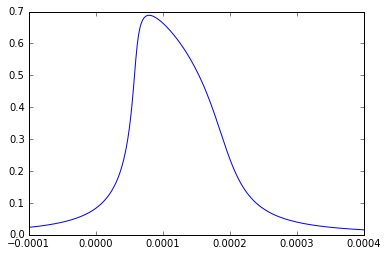

In [10]:
#-----------------------#
#   Calculated Values   #
#-----------------------#
lam = 2.*pi*hbar*c_light/E
theta_B = asin(0.5*lam/d_h)
psi_0 = 0.5*pi - theta_B + phi_a
psi_h = 0.5*pi + theta_B + phi_a

C_pol = 1.0 if pol == 's' else cos(2.*theta_B)
gamma_0 = cos(psi_0)
gamma_h = cos(psi_h)
gamma   = gamma_h/gamma_0

chi_rhr = abs_chi_rh * sin(0.5*arg_crh_over_cih); 
chi_rhi =-abs_chi_rh * cos(0.5*arg_crh_over_cih); 
chi_ihr =-abs_chi_ih * sin(0.5*arg_crh_over_cih);
chi_ihi =-abs_chi_ih * cos(0.5*arg_crh_over_cih);

chi_0    = chi_r0  + 1j*chi_i0 
chi_h    = chi_rhr + 1j*chi_rhi + 1j*(chi_ihr + 1j*chi_ihi)
chi_hbar = chi_rhr - 1j*chi_rhi + 1j*(chi_ihr - 1j*chi_ihi)

chih_times_chihbar = abs_chi_rh**2 - abs_chi_ih**2\
    + 2.0*1j*(chi_rhr*chi_ihr - chi_ihi*chi_rhi) 
abs_chih_over_chihbar = (abs_chi_rh**2 + abs_chi_ih**2\
    - 2.*(chi_rhr*chi_ihi - chi_rhi*chi_ihr))/(abs_chi_rh**2 + abs_chi_ih**2 + 2.*(chi_rhr*chi_ihi - chi_rhi*chi_ihr))

D_theta_0s = -0.5*chi_0*(1.0 - gamma)/sin(2.0*theta_B)

#---------------#
#   Functions   #
#---------------#

def eta(D_theta):
    return (D_theta - D_theta_0s) * sin(2.0*theta_B)\
        /(abs(C_pol)*sqrt(abs(gamma))*sqrt(chih_times_chihbar))

def psi(D_theta):
    return eta(D_theta) - sign(eta(D_theta).real)*sqrt(eta(D_theta)**2 + sign(gamma.real))

def R(D_theta):
    return abs_chih_over_chihbar * abs(psi(D_theta))**2

#----------------#
#   Print Data   #
#----------------#
print ('E:                   ' , E/e_charge, ' eV')
print ('lambda:              ' , lam*1e10, ' A')
print ('theta_B:             ' , theta_B/pi*180.)
print ('psi_0:               ' , psi_0/pi*180.)
print ('psi_h:               ' , psi_h/pi*180.)
print ('gamma_0:             ' , gamma_0)
print ('gamma_h:             ' , gamma_h)
print ('gamma:               ' , gamma)
print ('chi_h*chi_hbar:      ' , chih_times_chihbar, chi_h*chi_hbar)
print ('abs(chi_h/chi_hbar): ' , abs_chih_over_chihbar, abs(chi_h/chi_hbar))
print ('D_theta_0s:          ' , D_theta_0s)

#----------#
#   Plot   #
#----------#

x = np.arange(-.0001, .0004, 2e-6)
points = [R(x).real for x in x]
plt.plot(x, points)
plt.show()


The equation for the rocking curve of a crystal with a constant strain gradient is given by

$$R_n(q_0)=\frac{|\sigma_h|^2}{4|B|}\lvert\frac{D(-1-\nu,-i\sqrt{i/4B}\cdot q_0)}{D(-\nu,-i\sqrt{i/4B}\cdot q_0)}\rvert^2$$

with variables as functions of variables. To programatically model this equation it must be broken apart in order for the user to assign it desired values.


To begin one can extract the expression for $\sigma_h$ and, thinking ahead, its partner $\sigma_\bar{h}$.

$$\sigma_h=\frac{Ck\chi_h}{2|\gamma_h|},\ \sigma_\bar{h}=\frac{Ck\chi_\bar{h}}{2|\gamma_\bar{h}|}$$




In [11]:
k =2*pi/lam
gamma_hbar = gamma_h
sigma_h = (C_pol*k*chi_h)/(2*abs(gamma_h))
sigma_hbar = (C_pol*k*chi_hbar)/(2*abs(gamma_hbar))

B is defined as 

$$B=\frac{1}{2}b G_h cos(\phi_a\gamma_0\gamma_h).$$

In [12]:
G_h = 2*pi/d_h
B = 0.5*(b*G_h*cos(phi_a*gamma_0*gamma_h))

Thus we define the Cool Dude Factor

$$CDF=\frac{|\sigma_h|^2}{4|B|}$$

and the remaining part of the equation as the Chill Bro Ratio, $CBR$, and $R_n(q_0)$ becomes

$$R_n(q_0) = CDF\cdot|CBR|^2.$$

In [13]:
cool_dude = (abs(sigma_h)**2)/(4*abs(B))

To establish the Chill Bro Ratio one must elucidate the function D(a,z). This function is one of three so called parabolic cylinder functions (AKA Weber Functions) which are solutions to the differential equation 

$$\frac{d^2f}{dz^2}+(\tilde{a}z^2+\tilde{b}z+\tilde{c})f=0.$$

Conveniently the python package scipy includes this function as part of its programming. However, before excution the variables a and z must be assigned. To do this values for $\nu$ and $q_0$ must be equated as 

$$\nu=i \frac{\sigma_h\sigma_\bar{h}}{4B}$$
and
$$q_0=\frac{k}{2}(\frac{\chi_0}{\gamma_0}+\frac{\chi_0-\alpha}{|\gamma_h|})$$
where
$$\alpha = \frac{k_h^2-k^2}{k^2}=2\epsilon_h$$
and
$$2\epsilon_h=\chi_0+(\sqrt{|\gamma|}\sqrt{\chi_h\chi_\bar{h}}|C|)[-\eta\pm\sqrt{\eta^2+S(\gamma)}]$$
where $S(\gamma)$ is the sign of the $\gamma$ value and 
$$\eta = blah.$$
(laplace equation parabolic cylindrical coordinates etc.)

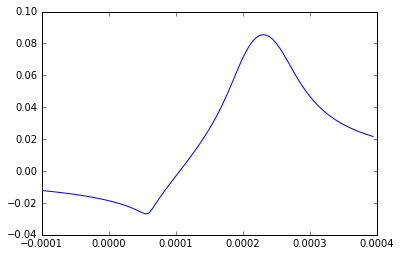

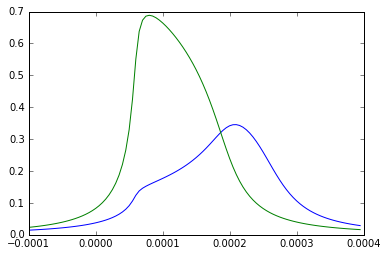

In [15]:
# Functions for strained crystal equation

def epsilon_h(D_theta):
    return (chi_0 + sqrt(abs(gamma))*sqrt(chi_h*chi_hbar)\
        *abs(C_pol)*(-1*eta(D_theta) - sign(eta(D_theta).real)\
        *sqrt(eta(D_theta)**2 + sign(gamma.real))))/2
def alpha(D_theta): return 2*epsilon_h(D_theta)
def q_0(D_theta): return k/2*(chi_0/gamma_0 + (chi_0 - alpha(D_theta))/abs(gamma_h))

def z(D_theta): return -1j*sqrt(1j/4/B)*q_0(D_theta)
    
def D(a,z): return mp.pcfd(a,z)
    
def chill_bro(D_theta):
    nu = 1j*(sigma_h*sigma_hbar)/(4*B)
    a_num = -1-nu
    a_den = -nu
    return D(a_num, z(D_theta))/D(a_den, z(D_theta))

def R_2(D_theta): return cool_dude * abs(chill_bro(D_theta))**2


# Decimal Place Sensitivity, doesn't help much over 20 at the moment
mp.dps=20


# Something to help with testing
a =[]
y=[]
t = np.arange(-1e-4,4e-4,5e-6)
for t in t:
    if True:# x < -1e-5 or x > .0004:
        try:

            y.append(R_2(t))
            a.append(t)
            #print("good"  + str(x))
        except:
            print("not sensitive enough at " + str(x))
            break
    else:
        y.append(0)
        a.append(t)


#Plot D over D ratio
d = [chill_bro(a).real for a in a]
plt.plot(a,d)
plt.show()

#Plot Perfect vs Strained Crystal
points = [R(a).real for a in a]
plt.plot(a, y, a, points)
plt.show()
